In [1]:
import numpy as np
import import_ipynb
#import numpy.linalg as LA
#import LMM as lmm
import random
import time
import os
import pandas as pd
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
from statsmodels.graphics.api import abline_plot
import seaborn as sns

np.random.seed(10)

def get_binary_covariate(covariate, covariate_level, data=data):
    covariate_list = np.zeros((data.obs.shape[0]))
    for i in range(data.obs.shape[0]):
        ### select the ith element of 
        if data.obs[[covariate]].squeeze()[i] == covariate_level:
            covariate_list[i] = 1
    return covariate_list


NameError: name 'data' is not defined

In [2]:
#### import the immune subpopulation of the rat samples
data = sc.read('/home/delaram/scLMM/input_data_designMat/inputdata_rat_set1_countData_2.h5ad') ## attributes removed
data.var_names_make_unique()
# a.obs['orig.ident'].head()
### renaming the meta info column names: https://github.com/theislab/scvelo/issues/255
data.__dict__['_raw'].__dict__['_var'] = data.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

data_numpy = data.X.toarray()
cell_sums = np.sum(data_numpy,axis=1) # row sums - library size
gene_sums = np.sum(data_numpy,axis=0) # col sums - sum reads in a gene
gene_vars = np.var(data_numpy, axis=0)
data_numpy = data_numpy[:,gene_sums != 0]


data_sub = data_numpy
strain = data.obs.strain
#### sample metadata
y_cluster =data.obs.cluster 
y_sample = data.obs.sample
y_sample = data.obs[['sample']].squeeze()
y_strain_str = data.obs[['strain']].squeeze()

y_strain = get_binary_covariate('strain', 'DA', data=data)


## working with the rat data
num_cells = data_sub.shape[0]
num_genes = data_sub.shape[1]
num_genes = 2000

#### select num_genes genes based on variance
### calculate the variance for each gene
gene_vars = np.var(data_numpy, axis=0)
### select the top num_genes genes with the highest variance
gene_idx = np.argsort(gene_vars)[::-1][0:num_genes]
### subset the data matrix to the top num_genes genes
data_numpy = data_numpy[:, gene_idx]

#### randomly select num_genes genes
#gene_idx = random.sample(range(0, data_numpy.shape[1]), num_genes)
#data_numpy = data_numpy[:, gene_idx]

y = data_numpy


NameError: name 'get_binary_covariate' is not defined

In [ ]:
### generating the design matrix for the rat data

# x = y_strain ## only strain as a covariate
y_DA_01 = get_binary_covariate('sample', 'DA_01')
y_LEW_01 = get_binary_covariate('sample', 'LEW_01')

### make a design matrix with the y_strain, y_DA_01, y_LEW_01
x = np.column_stack((y_strain, y_DA_01, y_LEW_01))
#x = sm.add_constant(x) ## adding the intercept
### print the head of the design matrix
print(x[0:3,:])
### number of columns in the design matrix - number of covariates (+1 for the intercept)
num_vars = x.shape[1]

In [ ]:
### fit a poisson regression model to each gene and save the results

### make an empty array to store the p-values and coefficients
pvalue = []
coefficient = []
yhat = []
tvalues = []
resid_pearson = []
resid_deviance = []
resid_response = []
resid_working = []
fittedvalues = []
nobs = []
models = []

pearson_chi2 = []
deviance = []
null_deviance = []

### time the fitting process
start_time = time.time()

for i in range(len(y[0])):
    y_a_gene = y[:, i]
    model = sm.GLM(y_a_gene, x, family=sm.families.Poisson())
    result = model.fit()
    #print(result.summary())
    
    models.append([result])
    coefficient.append([result.params])
    pvalue.append([result.pvalues]) ## yhat == fittedvalue == mu
    yhat.append([result.predict()])
    fittedvalues.append([result.fittedvalues])

    nobs.append([result.nobs])
    tvalues.append([result.tvalues])
    resid_pearson.append([result.resid_pearson])
    resid_deviance.append([result.resid_deviance])
    resid_response.append([result.resid_response])
    resid_working.append([result.resid_working])
    
    pearson_chi2.append([result.pearson_chi2])
    deviance.append([result.deviance])
    null_deviance.append([result.null_deviance])

end_time = time.time()
print('time to fit the model: ', end_time - start_time)

pvalue = np.asarray(pvalue).reshape(num_genes, num_vars)
coefficient = np.asarray(coefficient).reshape(num_genes, num_vars)
tvalues = np.asarray(tvalues).reshape(num_genes, num_vars)
#### print the head of the pvalues
print(pvalue[0:5, :])

yhat = np.asarray(yhat).reshape(num_genes, num_cells)
fittedvalues = np.asarray(fittedvalues).reshape(num_genes, num_cells)
resid_pearson = np.asarray(resid_pearson).reshape(num_genes, num_cells)
resid_deviance = np.asarray(resid_deviance).reshape(num_genes, num_cells)
resid_response = np.asarray(resid_response).reshape(num_genes, num_cells)
resid_working = np.asarray(resid_working).reshape(num_genes, num_cells)
nobs = np.asarray(nobs).reshape(num_genes, 1)

pearson_chi2 = np.asarray(pearson_chi2).reshape(num_genes, 1)
deviance = np.asarray(deviance).reshape(num_genes, 1)
null_deviance = np.asarray(null_deviance).reshape(num_genes, 1)


In [3]:
#### chosing a random gene to plot
i = 800 ## gene index
result = models[i][0] 
fittedvalues_i = fittedvalues[i]
y_i = y[:, i]

### get the summary of the model
print(result.summary())

NameError: name 'models' is not defined

NameError: name 'fittedvalues_i' is not defined

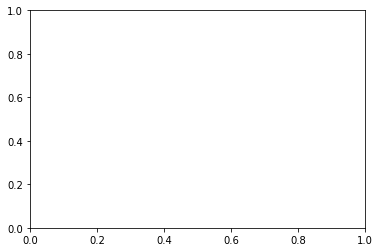

In [4]:
### diagnostic plots of the model outputs
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots()
ax.scatter(fittedvalues_i, y[:, i])
line_fit = sm.OLS(y_i, sm.add_constant(fittedvalues_i, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax, alpha=0.5)

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values')

sns.jointplot(fittedvalues_i, y[:, i], kind='scatter', stat_func=None, color='b', height=4)
sns.set_context(font_scale=0.9)                                                  
plt.title('Model Fit Plot')
plt.xlabel('Fitted values')
plt.ylabel('Observed values')
## change the size of the text in plot
plt.rc('font', size=10)

fig, ax = plt.subplots()
resid_pearson_i = resid_pearson[i]
ax.scatter(fittedvalues_i, resid_pearson_i, alpha=0.1)
#ax.hlines(0, 0, 7)
#ax.set_xlim(0, 7)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

sns.jointplot(fittedvalues_i, resid_pearson_i, kind='scatter', stat_func=None, color='b', height=4)
sns.set_context(font_scale=0.9)                                                  
plt.title('Model Fit Plot')
plt.xlabel('Fitted values')
plt.ylabel('Pearson Residuals')
## change the size of the text in plot
plt.rc('font', size=10)
plt.show()

from scipy import stats
fig, ax = plt.subplots()
resid = resid_deviance[i]
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals')

from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

In [5]:
#### calculate the goodness of fit of GLM model
# https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html#statsmodels.genmod.generalized_linear_model.GLMResults

### statsmodels GLM source code:
# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/genmod/families/links.py

### poisson family link function
# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/genmod/families/family.py


print('log-likelihood of the model: ', result.llf)

### calculate the null deviance manually - float
# NullDeviance = 2*(LL(SaturatedModel)−LL(NullModel))
# The value of the deviance function for the model fit with a constant as the only regressor
# GLMResults.llf: Value of the loglikelihood function evalued at params. See statsmodels.families.family for distribution-specific loglikelihoods.
null_deivance_i = 2*(result.llnull - result.llf)
print('null deviance manual calculation: ', null_deivance_i) ## why the result is different from the result.null_deviance?
print('null deviance: ',result.null_deviance)


### calculate the deviance - float
# The value of the deviance function for the model fit with the full set of regressors
# ResidualDeviance = 2*(LL(SaturatedModel)−LL(ProposedModel))
deviance_i =result.deviance 
print('deviance: ', deviance_i)


### Response residual - array
# The response residuals are defined as endog - fittedvalues
response_residual_i = y_i - fittedvalues_i
print('response residual manual: ', response_residual_i[:3])
print('response residual is: ', resid_response[i][:3])

### Deviance residual - how is this calculated? - array
print('residual deviance is: ', resid_deviance[i][1:3])

  
## Working residual - response residuals scaled by the derivative of the inverse of the link function
# The working residuals are defined as resid_response/link’(mu)
# mu: The inverse of the link function at the linear predicted values. - then why is mu=yhat instead of mu=e^yhat? 
# https://www.statsmodels.org/dev/glm.html#link-functions
resid_working_i = resid_response[i]/result.family.link.deriv(result.mu) ## derivatives of the link function
print('working residual manual: ', resid_working_i[:3])
print('working residual is: ', resid_working[i][:3])


### The Pearson residuals - response residuals scaled by the square root of the variance function
# (endog - mu)/sqrt(VAR(mu)) where VAR is the distribution specific variance function
resid_pearson_i = (y_i - result.mu)/np.sqrt(result.family.variance(result.mu)) ## variance function of the poisson family is power?
print('pearson residual manual: ', resid_pearson_i[:3])
print('pearson residual is: ', resid_pearson[i][:3])


### calculate the Pearson’s Chi-Squared statistic 
# the sum of the squares of the Pearson residuals.
Pearson_Chi_Squared_i = sum(resid_pearson[i]**2)
print('Pearson_Chi_Squared manual: ', Pearson_Chi_Squared_i)
print('Pearson_Chi_Squared: ', result.pearson_chi2)


### calculate the BIC - float
# BIC : deviance - df_resid * log(nobs)
BIC_i = deviance_i - result.df_resid * np.log(nobs[0])
print('BIC manual: ', BIC_i)
print('BIC is: ', result.bic)


### calculate the AIC - float
# AIC: aike Information Criterion
# -2 * llf + 2 * (df_model + 1)
## df_model: rank of the regression matrix excluding the intercept:  df_model = k_exog - 1 = 0 is only strain is included
AIC_i = deviance_i + 2 * (result.df_model + 1)
AIC_i = -2 * result.llf + 2 * (result.df_model + 1)
print('AIC manual: ', AIC_i)
print('AIC is: ', result.aic)


### calculate the pseudo R-squared - float
pseudo_rsquared_i = 1 - abs(result.deviance/result.null_deviance)
print('pseudo R-squared manual: ', pseudo_rsquared_i)
#print('pseudo R-squared is: ', result.pseudo_rsquared)

### calculate the Wald test - float
# result.wald_test('x1 = x2 = 0')

# GLMResults.wald_test : Compute a Wald-test for a joint linear hypothesis.
# GLMResults.compare_lr_test : Likelihood ratio test for comparing two models.\n"

print(resid_response.T.shape)
print(y.shape)

NameError: name 'result' is not defined

In [ ]:
def plot_pca(pca, num_components_to_plot, title='PCA of the data matrix'):
    
    for i in range(1, num_components_to_plot):
        ## color PCA based on strain
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=strain_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.legend(handles=[mpatches.Patch(color='springgreen', label='LEW'),
                            mpatches.Patch(color='hotpink', label='DA')])
        plt.show()

        ## color PCA based on cluster
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=c, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.show()

        ###  ## color PCA based on sample
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=sample_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='palegreen', label='LEW_01'),
                            mpatches.Patch(color='forestgreen', label='LEW_02'),
                            mpatches.Patch(color='pink', label='DA_01'),
                            mpatches.Patch(color='orchid', label='DA_02')], loc='best')
        plt.show()


    # plot the variance explained by each PC
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Variance explained by each PC')
    plt.xlabel('PC')
    plt.ylabel('Variance explained')
    plt.show()



#### generating the list of colors for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(y_cluster)))) ### set the color for each cluster
my_color = {}
### define a dictionary to map the cluster number to the color
list_levels = list(set(y_cluster))
for i in range(len(set(list_levels))):
    my_color[list_levels[i]] = colors[i]
### generate a list containing the corresponding color for each cluster
c = [my_color[y_cluster[i]] for i in range(len(y_cluster))]


### generating the list of colors for samples
my_color = {'LEW_01': 'palegreen', 'LEW_02':'forestgreen', 'DA_01':'pink', 'DA_02':'orchid'}
### generate a list containing the corresponding color for each sample
sample_color = [my_color[y_sample[i]] for i in range(len(y_sample))]

my_color = {'LEW': 'springgreen', 'DA':'hotpink'}
strain_color = [my_color[y_strain_str[i]] for i in range(len(y_strain_str))]

### applying PCA to the data matrix
num_components = 10


In [6]:
num_components = 10
### using PCA directly
#pca = PCA(n_components=20)
#pca.fit(y.T)
import umap

### using pipeline to scale the data first
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(y.T)
pca = pipeline.named_steps['pca']

#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
print(pca.noise_variance_)
print('len of pca components: ', len(pca.components_[0]))

plot_pca(pca, 3, title='PCA of the data matrix')

### apply UMAP to teh PCA components
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca.components_.T)
print('embedding shape: ', embedding.shape)
### plot the UMAP embedding
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=strain_color, s=1)
plt.title('UMAP embedding of the PCA components')
plt.legend(handles=[mpatches.Patch(color='springgreen', label='LEW'),
                    mpatches.Patch(color='hotpink', label='DA')])
plt.show()


NameError: name 'num_components' is not defined

In [ ]:

### applying PCA to the response residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(resid_response)
pca = pipeline.named_steps['pca']

#pca = PCA(n_components=20)
#pca.fit(resid_response)

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca, 10, title='PCA of response residuals')

In [ ]:
### applying PCA to the pearson residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(resid_pearson)
pca = pipeline.named_steps['pca']

#pca = PCA(n_components=20)
#pca.fit(resid_response)

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca, 10, title='PCA of pearson residuals')


In [ ]:
### applying PCA to the deviance residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(resid_deviance)
pca = pipeline.named_steps['pca']

#pca = PCA(n_components=20)
#pca.fit(resid_response)

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca, 10, title='PCA of deviance residuals')
